In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from collections import Counter
import cryptoaml.datareader as cdr

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

from skmultiflow.meta import LearnNSE
from skmultiflow.meta import LeverageBagging
from skmultiflow.trees import HoeffdingTree
from sklearn.tree import DecisionTreeClassifier
from skmultiflow.meta import AdaptiveRandomForest
from cryptoaml.models import AdaptiveXGBoostClassifier
from cryptoaml.models import AdaptiveStackedBoostClassifier

from sklearn.exceptions import UndefinedMetricWarning

from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import NeighbourhoodCleaningRule

from cryptoaml.metrics import (
    results_table, 
    plot_metric_dist,
    plot_feature_imp,
    print_model_params, 
    plot_result_matrices,
    display_metrics_stats,
    elliptic_time_indexed_results
)

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

/home/delinvas/anaconda3/envs/btc-classifier/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.



In [2]:
def evaluate_batch_incremental(model, data, t_eval=35):
    
    results = {}
    results_time = []
    true_test = []
    predictions_test = []
    
    for ts in np.arange(data["ts"].min(), data["ts"].max()):
        
        # get training data for the current timestep 
        train_set = data[data["ts"] == ts]
        train_set_X = train_set.iloc[:,:-1]
        train_set_y = train_set["class"]      

        # partially fit model 
        model.partial_fit(train_set_X.values, train_set_y.values)    

        # get test data for the current timestep + 1 
        test_set = data[data["ts"] == ts + 1]
        test_set_X = test_set.iloc[:,:-1].values
        test_set_y = test_set["class"].values
    
        # predict test data for the current timestep + 1
        y_pred = model.predict(test_set_X)
        evaluation_f1 = f1_score(test_set_y, y_pred, average='binary', labels=np.unique(y_pred))
        evaluation_recall = recall_score(test_set_y, y_pred, average='binary', labels=np.unique(y_pred))
        evaluation_precision = precision_score(test_set_y, y_pred, average='binary', labels=np.unique(y_pred))
        evaluation_accuracy = accuracy_score(test_set_y, y_pred, normalize=True)
        
        # take note of predictions after timestep 34 (evaluation set)
        if ts+1 >= t_eval:
            true_test.append(test_set_y)
            predictions_test.append(y_pred)
            label_count = test_set["class"].value_counts()
            results_time.append({"timestep": ts + 1, 
                                 "score":evaluation_f1, 
                                 "total_pos_label": label_count.tolist()[1]}) 

            
    test_results = {}
    f1_score_test = f1_score(np.concatenate(true_test, axis=0), 
                        np.concatenate(predictions_test, axis=0), 
                        average='binary')
    recall_score_test = recall_score(np.concatenate(true_test, axis=0),   
                                np.concatenate(predictions_test, axis=0), 
                                average='binary')
    precision_score_test = precision_score(np.concatenate(true_test, axis=0),   
                                      np.concatenate(predictions_test, axis=0), 
                                      average='binary')
    accuracy_score_test = accuracy_score(np.concatenate(true_test, axis=0),   
                                    np.concatenate(predictions_test, axis=0), 
                                    normalize=True)
    confusion_matrix_test = confusion_matrix(np.concatenate(true_test, axis=0), 
                                             np.concatenate(predictions_test, axis=0))
    
    test_results["f1"] = round(f1_score_test, 3)   
    test_results["recall"] = round(recall_score_test, 3)   
    test_results["precision"] = round(precision_score_test, 3)   
    test_results["accuracy"] = round(accuracy_score_test, 3)   
    test_results["confusion_matrix"] = confusion_matrix_test  
    
    results["test_results"] = test_results
    results["time_metrics"] = pd.DataFrame(results_time)   

    return results

In [3]:
def evaluate(feature_set, n_eval):
    elliptic = cdr.get_data("elliptic")
    data_eval = elliptic.train_test_split(train_size=0.7, 
                                     feat_set=feature_set, 
                                     inc_meta=False,
                                     inc_unknown=False)

    train_data = data_eval.train_X
    train_data["class"] = data_eval.train_y
    test_data = data_eval.test_X
    test_data["class"] = data_eval.test_y 
    data_eval = train_data.append(test_data, ignore_index=True)
    
    f_set = "elliptic"+"_"+feature_set
    experiment_3_results = {}
    experiment_3_results["ARF"] = {}
    experiment_3_results["AXGBr"] = {}
    experiment_3_results["AXGBp"] = {}
    experiment_3_results["ASXGB"] = {}
#     experiment_3_results["ARF"][f_set] = {}
    experiment_3_results["AXGBr"][f_set] = {}
    experiment_3_results["AXGBp"][f_set] = {}
    experiment_3_results["ASXGB"][f_set] = {}

    # 2. Adapative Random Forest
    print("Evaluating ARF")
    arf = AdaptiveRandomForest(performance_metric="kappa")
#     experiment_3_results["ARF"][f_set] = evaluate_batch_incremental(arf, data_eval, n_eval)
    
    # 2. Adapative Extreme Gradient Boosting with Replacement
    # 3. Adapative Extreme Gradient Boosting with Push
    # Adaptive XGBoost classifier parameters
    n_estimators = 30       # Number of members in the ensemble
    learning_rate = 0.3     # Learning rate or eta
    max_depth = 6           # Max depth for each tree in the ensemble
    max_window_size = 1000  # Max window size
    min_window_size = 1     # set to activate the dynamic window strategy
    detect_drift = False    # Enable/disable drift detection

    print("Evaluating AXGBr")
    AXGBr = AdaptiveXGBoostClassifier(update_strategy='replace',
                                      n_estimators=n_estimators,
                                      learning_rate=learning_rate,
                                      max_depth=max_depth,
                                      max_window_size=max_window_size,
                                      min_window_size=min_window_size,
                                      detect_drift=detect_drift)
    experiment_3_results["AXGBr"][f_set] = evaluate_batch_incremental(AXGBr, data_eval, n_eval)

    print("Evaluating AXGBp")
    AXGBp = AdaptiveXGBoostClassifier(update_strategy='push',
                                      n_estimators=n_estimators,
                                      learning_rate=learning_rate,
                                      max_depth=max_depth,
                                      max_window_size=max_window_size,
                                      min_window_size=min_window_size,
                                      detect_drift=detect_drift)
    experiment_3_results["AXGBp"][f_set] = evaluate_batch_incremental(AXGBp, data_eval, n_eval)

    # 4. Proposed Method
    print("Evaluating ASXGB")
    ASXGB = AdaptiveStackedBoostClassifier()
    experiment_3_results["ASXGB"][f_set] = evaluate_batch_incremental(ASXGB, data_eval, n_eval)
    
    elliptic_time_indexed_results(experiment_3_results)
    print(experiment_3_results)

Evaluating ARF
Evaluating AXGBr
Evaluating AXGBp
Evaluating ASXGB


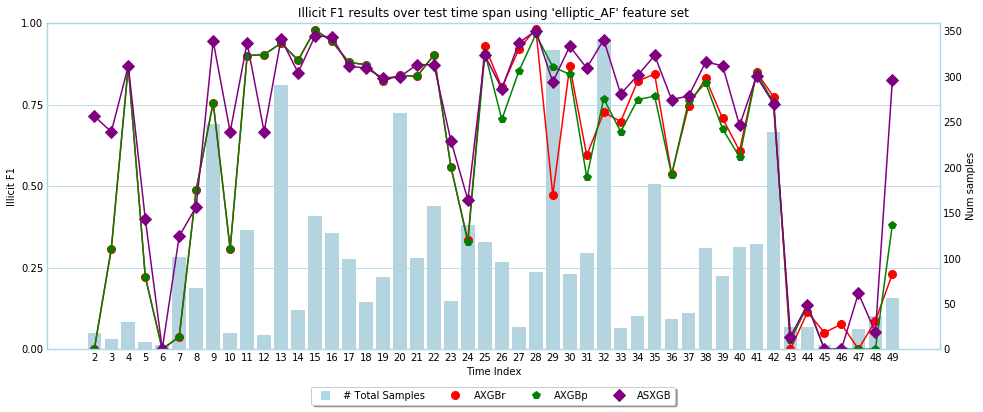

{'ARF': {}, 'AXGBr': {'elliptic_AF': {'test_results': {'f1': 0.739, 'recall': 0.676, 'precision': 0.814, 'accuracy': 0.951, 'confusion_matrix': array([[39188,   701],
       [ 1465,  3063]])}, 'time_metrics':     timestep     score  total_pos_label
0          2  0.000000               18
1          3  0.307692               11
2          4  0.867925               30
3          5  0.222222                8
4          6  0.000000                5
5          7  0.038095              102
6          8  0.488889               67
7          9  0.756219              248
8         10  0.307692               18
9         11  0.900000              131
10        12  0.903226               16
11        13  0.938272              291
12        14  0.886076               43
13        15  0.979167              147
14        16  0.943548              128
15        17  0.879121               99
16        18  0.872340               52
17        19  0.822695               80
18        20  0.840000         

In [4]:
evaluate("AF", 2)

Evaluating ARF
Evaluating AXGBr
Evaluating AXGBp
Evaluating ASXGB


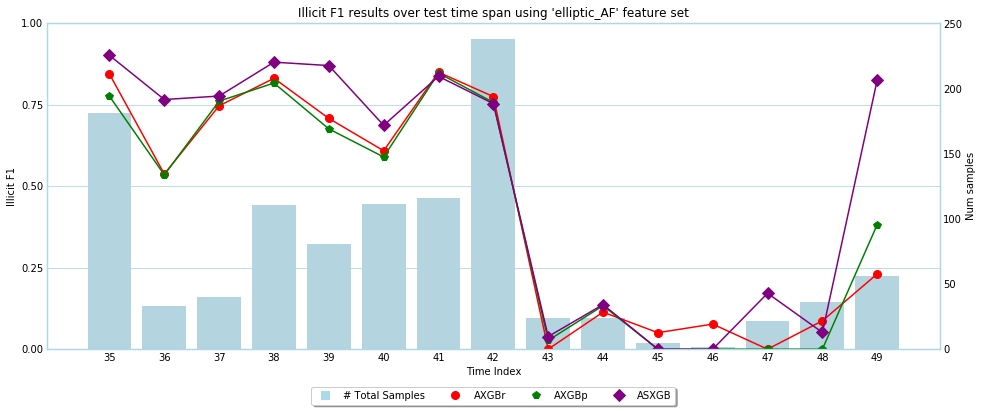

{'ARF': {}, 'AXGBr': {'elliptic_AF': {'test_results': {'f1': 0.648, 'recall': 0.719, 'precision': 0.59, 'accuracy': 0.949, 'confusion_matrix': array([[15045,   542],
       [  304,   779]])}, 'time_metrics':     timestep     score  total_pos_label
0         35  0.843501              182
1         36  0.537037               33
2         37  0.746269               40
3         38  0.830508              111
4         39  0.707547               81
5         40  0.608333              112
6         41  0.849206              116
7         42  0.774451              239
8         43  0.000000               24
9         44  0.113636               24
10        45  0.050633                5
11        46  0.076923                2
12        47  0.000000               22
13        48  0.086957               36
14        49  0.230769               56}}, 'AXGBp': {'elliptic_AF': {'test_results': {'f1': 0.639, 'recall': 0.722, 'precision': 0.572, 'accuracy': 0.947, 'confusion_matrix': array([[15003,   

In [6]:
evaluate("AF", 35)

In [ ]:
# evaluate("AF_NE", 2)

In [ ]:
# evaluate("AF_NE", 35)